# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание проекта.

В наше распоряжение попала база объявлений авто. Наша задача подготовить достаточно быструю в обучении и предсказании, но, в то же время достаточно точную модель определения рыночной стоимости авто по имеющимся признакам.

В ходе работы проведем предобработку, обучение моделей и выберем одну наиболее подходящую. Подробно каждый этап описан ниже. Работа завершается краткими выводами и рекомендациями.

### Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

### Определим константы

In [2]:
RNG = np.random.RandomState(0)

In [3]:
SCORER = 'neg_root_mean_squared_error'

In [4]:
CV = KFold(n_splits=3)

## Подготовка данных

### Загрузим данные и выведем сводное инфо.

In [5]:
data = pd.read_csv('autos.csv')

In [6]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Наблюдаем следующий задел для предобработки:

- Приведение типов данных. Необходимо обработать столбцы, связанные с датой / временем.

- Обработка пропусков. Исследуем пропуски и выберем стратегию замены ниже.

- Обработка явных и неявных дубликатов. Проверим на наличие и обработаем при необходимости.

- Исследуем и обработаем при необходимости выбросы и аномалии.

Начнем с обработки даты / времени, чтобы эти столбцы можно было включить в дальнейшие шаги предобработки данных. Имеются три столбца, связанных с датой / временем: DateCrawled, LastSeen, DateCreated. Во - первых изменим тип данных, во вторых разобьем каждый столбец отдельно на год /месяц / дату и т. д. Сохраним сведения в новые соответсвующие столбцы и удалим первоначальные столбцы.

In [8]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['LastSeen'] = pd.to_datetime(data['LastSeen'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])

In [9]:
data['dc_year'] = data['DateCrawled'].dt.year
data['dc_month'] = data['DateCrawled'].dt.month
data['dc_day'] = data['DateCrawled'].dt.day
data['dc_hour'] = data['DateCrawled'].dt.hour
data['dc_dayofweek'] = data['DateCrawled'].dt.dayofweek

In [10]:
data['ls_year'] = data['LastSeen'].dt.year
data['ls_month'] = data['LastSeen'].dt.month
data['ls_day'] = data['LastSeen'].dt.day
data['ls_hour'] = data['LastSeen'].dt.hour
data['ls_dayofweek'] = data['LastSeen'].dt.dayofweek

In [11]:
data['dcr_year'] = data['DateCreated'].dt.year
data['dcr_month'] = data['DateCreated'].dt.month
data['dcr_day'] = data['DateCreated'].dt.day
data['dcr_hour'] = data['DateCreated'].dt.hour
data['dcr_dayofweek'] = data['DateCreated'].dt.dayofweek

In [12]:
data.drop(['DateCrawled', 'LastSeen', 'DateCreated'], axis=1, inplace=True)

Преобразование даты / времени завершено. В текущем состоянии данные с технической точки зрения пригодны для машинного обучения (информативность признаков по существу рассмотрим ниже).

Ниже обработаем пропущенные значения.

In [13]:
missing_values = (data.isna().mean()*100).sort_values(ascending = False)
missing_values[missing_values != 0]

Repaired       20.079070
VehicleType    10.579368
FuelType        9.282697
Gearbox         5.596709
Model           5.560588
dtype: float64

Все пропущенные значения сосредоточены в колонках с категориальными признаками. Поскольку любая модель авто может комплектоваться различными типами кузовов, двигателей и коробок передач, целесообразно пропуски заменить заглушкой.

In [14]:
data['Repaired'] = data['Repaired'].fillna('unknown')

In [15]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')

In [16]:
data['FuelType'] = data['FuelType'].fillna('unknown')

In [17]:
data['Gearbox'] = data['Gearbox'].fillna('unknown')

In [18]:
data['Model'] = data['Model'].fillna('unknown')

In [19]:
missing_values = (data.isna().mean()*100).sort_values(ascending = False)
missing_values[missing_values != 0]

Series([], dtype: float64)

Пропуски обработаны.

Далее в соотв. с утвержденным планом обработаем дубликаты. Начнем с явных дубликатов, далее проверим и заменим при необходимости неявные дубликаты в колонках категориальных признаков.

In [20]:
data.duplicated().sum()

1706

In [21]:
data.drop_duplicates()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,...,ls_year,ls_month,ls_day,ls_hour,ls_dayofweek,dcr_year,dcr_month,dcr_day,dcr_hour,dcr_dayofweek
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,...,2016,4,7,3,3,2016,3,24,0,3
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,...,2016,4,7,1,3,2016,3,24,0,3
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,...,2016,4,5,12,1,2016,3,14,0,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,...,2016,3,17,17,3,2016,3,17,0,3
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,...,2016,4,6,10,2,2016,3,31,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,...,2016,3,21,10,0,2016,3,21,0,0
354365,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,...,2016,4,6,0,2,2016,3,14,0,0
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,...,2016,3,11,18,4,2016,3,5,0,5
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,...,2016,4,7,7,3,2016,3,19,0,5


In [22]:
categorical_columns = list(data.columns[data.dtypes == 'object'])
categorical_columns

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [23]:
data['VehicleType'].unique()

array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Дубликатов нет.

In [24]:
data['Gearbox'].unique()

array(['manual', 'auto', 'unknown'], dtype=object)

Дубликатов нет.

In [25]:
data['Model'].unique()

array(['golf', 'unknown', 'grand', 'fabia', '3er', '2_reihe', 'other',
       'c_max', '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo',
       'a_klasse', 'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'corsa', 'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra',
       'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       '156', 'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1',
       'insignia', 'combo', 'focus', 'tt', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',

In [26]:
mapper = {'1_reihe' : '1er', '2_reihe': '2er', '3_reihe' : '3er', '5_reihe': '5er', '6_reihe': '6er',
          'c_reihe': 'c_klasse', 'm_reihe': 'm_klasse', 'rangerover': 'range_rover', 'serie_1': '1er',
          'serie_2': '2er', 'serie_3': '3er'}

In [27]:
data['Model'] = data['Model'].replace(mapper)

In [28]:
data['Model'].unique()

array(['golf', 'unknown', 'grand', 'fabia', '3er', '2er', 'other',
       'c_max', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6er', 'panda', 'up', 'seicento', 'ceed', 'yeti', 'octavia', 'mii',
       'rx_reihe', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio

In [29]:
data['FuelType'].unique()

array(['petrol', 'gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [30]:
data['FuelType'] = data['FuelType'].replace({'petrol': 'gasoline', 'lpg': 'cng'})

In [31]:
data['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [32]:
data['Repaired'].unique()

array(['unknown', 'yes', 'no'], dtype=object)

Достаточно большое количество дубликатов обработано в названиях моделей (по большей части связанных с вариантами одного наименования на разных языках) и несколько дубликатов в видах топлива.

Далее перейдем к обработке выбросов и аномалий. Выведем гистограммы и воспользуемся методом .describe().

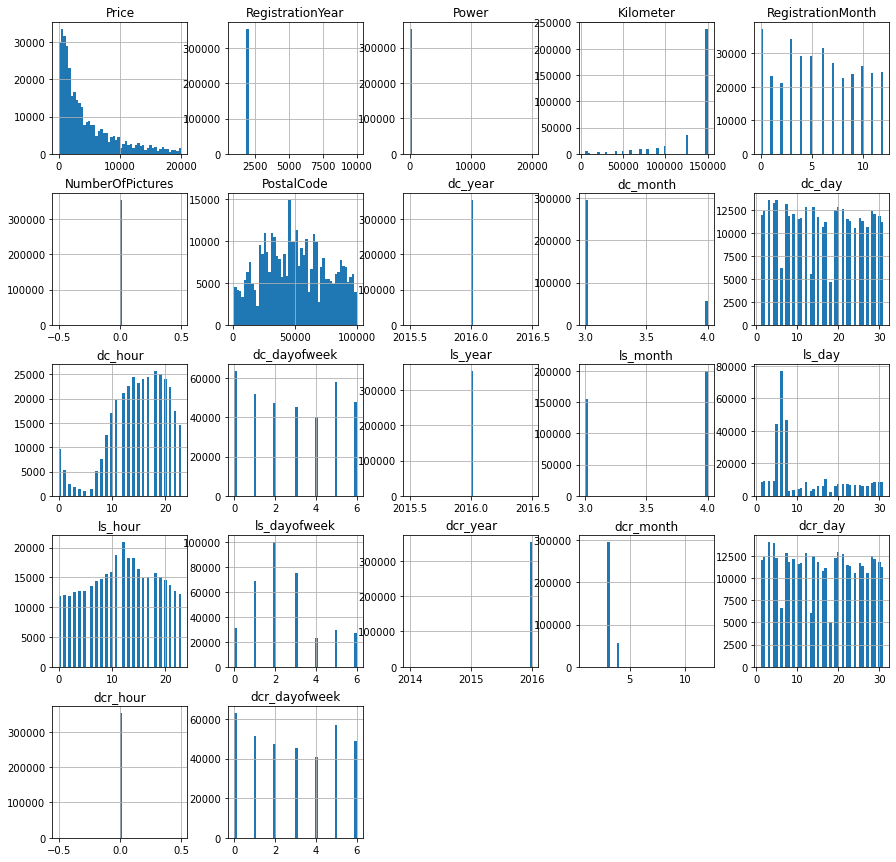

In [33]:
data.hist(bins = 50, figsize = (15, 15))
plt.show()

In [34]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,dc_year,dc_month,dc_day,...,ls_year,ls_month,ls_day,ls_hour,ls_dayofweek,dcr_year,dcr_month,dcr_day,dcr_hour,dcr_dayofweek
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000,354369.0,354369.000000,354369.000000,...,354369.0,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087,2016.0,3.162387,15.852783,...,2016.0,3.564987,11.963456,11.813835,2.529361,2015.999924,3.160189,15.859689,0.0,2.891737
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248,0.0,0.368806,9.116311,...,0.0,0.495759,8.886562,6.516410,1.645033,0.009046,0.376284,9.123133,0.0,2.075846
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,2016.0,3.000000,1.000000,...,2016.0,3.000000,1.000000,0.000000,0.000000,2014.000000,1.000000,1.000000,0.0,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000,2016.0,3.000000,8.000000,...,2016.0,3.000000,6.000000,7.000000,1.000000,2016.000000,3.000000,8.000000,0.0,1.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000,2016.0,3.000000,16.000000,...,2016.0,4.000000,7.000000,12.000000,2.000000,2016.000000,3.000000,16.000000,0.0,3.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000,2016.0,3.000000,24.000000,...,2016.0,4.000000,19.000000,17.000000,3.000000,2016.000000,3.000000,24.000000,0.0,5.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,2016.0,4.000000,31.000000,...,2016.0,4.000000,31.000000,23.000000,6.000000,2016.000000,12.000000,31.000000,0.0,6.000000


В первую очередь удалим неинформативные столбцы.

In [35]:
data.drop(['NumberOfPictures', 'dc_year', 'ls_year', 'dcr_hour'], axis = 1, inplace = True)

Далее обработаем выбросы / аномалии методом .clip(). Столбцы, содержащие выбросы выделены ниже.

In [36]:
outliers_cols = ['RegistrationYear', 'Power']

In [37]:
data[outliers_cols] = data[outliers_cols].clip(lower = data[outliers_cols].quantile(0.01).astype(int),
                                             upper = data[outliers_cols].quantile(0.99).astype(int),
                                             axis = 1)

После обработки аномалий проверим нулевые значения в столбцах цены и мощности. Гипотеза состоит в том, что нулевая цена вызвана старыми годами выпуска и пр. подобными факторами, т. е. характерна для "автохлама". Проверим.

<AxesSubplot:>

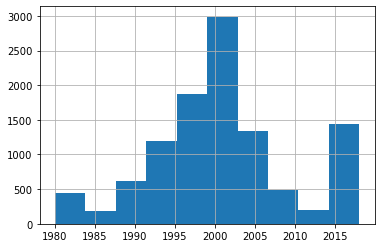

In [38]:
data[data['Price'] == 0]['RegistrationYear'].hist()

<AxesSubplot:>

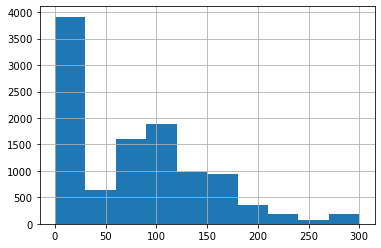

In [39]:
data[data['Price'] == 0]['Power'].hist()

Как видим выше, гипотеза не подтверждается - по нулевым ценам "продают" свежие резвые авто. Цена является целевым признаком - наличие ошибок в заполнении приведет к снижению точности моделей. придется удалять. Остается выбрать нижнюю границу для удаления.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
qntile,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055,0.06,0.065,0.07,0.075,0.08,0.085,0.09,0.095
price,0.00,0.000,0.00,0.000,0.00,45.000,100.00,150.000,200.00,219.000,250.00,299.000,300.00,350.000,350.00,400.000,400.00,450.000


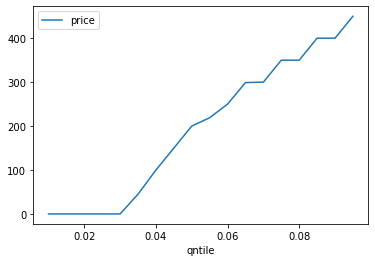

In [40]:
qpl = []
for i in range(10, 100, 5):
    qpl.append([i/1000, data['Price'].quantile(i/1000)])
qpl = pd.DataFrame(qpl, columns = ['qntile', 'price'])
qpl.plot(x = 'qntile', y = 'price')
qpl.T

Строгим научным методом определили, что цены неотличимы от нулевых вплоть до 3.5 квантиля. 3.5 квантилю распределения цены соотв. значение 45 евро. Возьмем это значение в качестве нижней границы интервала, нежно сохранив ненулевые значения.

In [41]:
data.drop(data[data['Price'] < 45].index, axis = 0, inplace = True)

In [42]:
data.reset_index(drop = True, inplace = True)

Как видим на графике ниже, авто с нулевой мощностью двигателя выставляются в том числе по вполне осязаемой стоимости. Повторим аналогичный расчет для показтеля мощности - мощность является ключевой характеристикой авто. Некорректные значения придется удалить. Заполнение синтетическими величинами может привести к ошибкам в обучении моделей.

<AxesSubplot:>

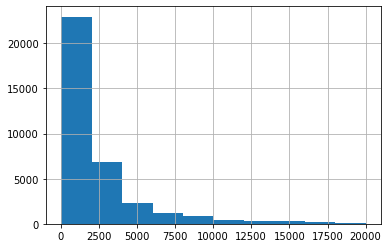

In [43]:
data[data['Power'] == 0]['Price'].hist()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
qntile,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19
power,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,41.00,46.00,50.00,54.00,54.00,58.00,59.00,60.00,60.00


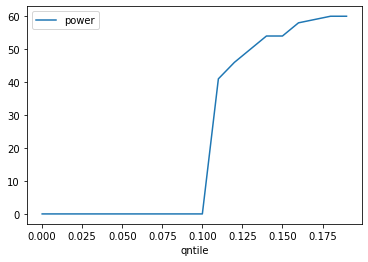

In [44]:
qpl = []
for i in range(0, 20, 1):
    qpl.append([i/100, data['Power'].quantile(i/100)])
qpl = pd.DataFrame(qpl, columns = ['qntile', 'power'])
qpl.plot(x = 'qntile', y = 'power')
qpl.T

Выделим 11й квантиль со значением 40 и ниже.

In [45]:
data.drop(data[data['Power'] < 41].index, axis = 0, inplace = True)

После удаления большого количества строк сбросим индексы и проверим результаты.

In [46]:
data.reset_index(inplace = True, drop = True)

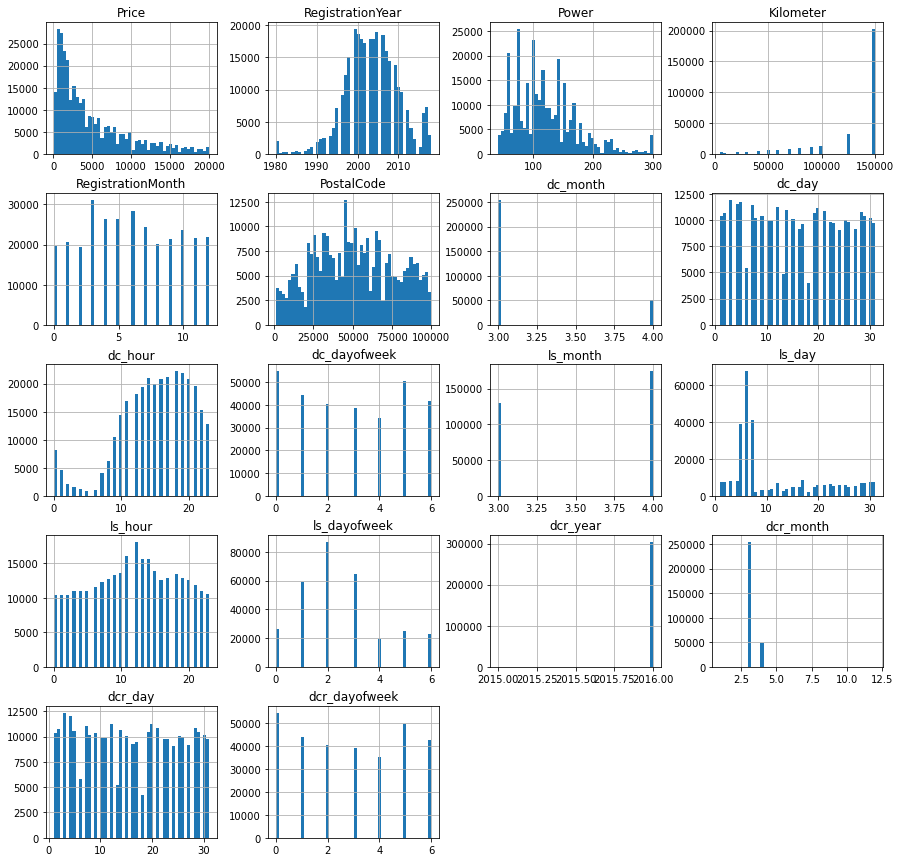

In [47]:
data.hist(bins = 50, figsize = (15, 15))
plt.show()

In [48]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,dc_month,dc_day,dc_hour,dc_dayofweek,ls_month,ls_day,ls_hour,ls_dayofweek,dcr_year,dcr_month,dcr_day,dcr_dayofweek
count,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000,304772.000000
mean,4831.044991,2003.429688,120.455262,128643.625399,5.970522,51182.503859,3.163266,15.836960,14.969082,2.888166,3.574639,11.851525,11.795194,2.522328,2015.999921,3.161002,15.844943,2.899673
std,4588.863973,6.558316,51.800338,36488.968508,3.597112,25754.362535,0.369609,9.128087,5.413144,2.081171,0.494398,8.856595,6.534334,1.635533,0.008874,0.378026,9.135007,2.079664
min,45.000000,1980.000000,41.000000,5000.000000,0.000000,1067.000000,3.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000
25%,1350.000000,1999.000000,76.000000,125000.000000,3.000000,30926.000000,3.000000,8.000000,12.000000,1.000000,3.000000,6.000000,7.000000,1.000000,2016.000000,3.000000,8.000000,1.000000
50%,3150.000000,2003.000000,110.000000,150000.000000,6.000000,50181.000000,3.000000,16.000000,16.000000,3.000000,4.000000,7.000000,12.000000,2.000000,2016.000000,3.000000,16.000000,3.000000
75%,6980.000000,2008.000000,150.000000,150000.000000,9.000000,71720.000000,3.000000,24.000000,19.000000,5.000000,4.000000,19.000000,17.000000,3.000000,2016.000000,3.000000,24.000000,5.000000
max,20000.000000,2018.000000,300.000000,150000.000000,12.000000,99998.000000,4.000000,31.000000,23.000000,6.000000,4.000000,31.000000,23.000000,6.000000,2016.000000,12.000000,31.000000,6.000000


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304772 entries, 0 to 304771
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              304772 non-null  int64 
 1   VehicleType        304772 non-null  object
 2   RegistrationYear   304772 non-null  int64 
 3   Gearbox            304772 non-null  object
 4   Power              304772 non-null  int64 
 5   Model              304772 non-null  object
 6   Kilometer          304772 non-null  int64 
 7   RegistrationMonth  304772 non-null  int64 
 8   FuelType           304772 non-null  object
 9   Brand              304772 non-null  object
 10  Repaired           304772 non-null  object
 11  PostalCode         304772 non-null  int64 
 12  dc_month           304772 non-null  int64 
 13  dc_day             304772 non-null  int64 
 14  dc_hour            304772 non-null  int64 
 15  dc_dayofweek       304772 non-null  int64 
 16  ls_month           3

В ходе предобработки перекодировали столбцы, связанные с датой / временем, заполнили пропущенные значения, обработали дубликаты, а также обработали выбросы и аномалии.

## Обучение моделей.

Подготовим матрицу признаков и выделим таргет.

In [50]:
features = data.drop('Price', axis = 1)
target = data['Price']

Числовые и категориальные колонки переопределим. Для начала выведем сводное инфо по признакам.

In [51]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304772 entries, 0 to 304771
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        304772 non-null  object
 1   RegistrationYear   304772 non-null  int64 
 2   Gearbox            304772 non-null  object
 3   Power              304772 non-null  int64 
 4   Model              304772 non-null  object
 5   Kilometer          304772 non-null  int64 
 6   RegistrationMonth  304772 non-null  int64 
 7   FuelType           304772 non-null  object
 8   Brand              304772 non-null  object
 9   Repaired           304772 non-null  object
 10  PostalCode         304772 non-null  int64 
 11  dc_month           304772 non-null  int64 
 12  dc_day             304772 non-null  int64 
 13  dc_hour            304772 non-null  int64 
 14  dc_dayofweek       304772 non-null  int64 
 15  ls_month           304772 non-null  int64 
 16  ls_day             3

In [52]:
categorical_features = list(features.columns[features.dtypes == 'object'])
categorical_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [53]:
numeric_features = list(features.columns[features.dtypes != 'object'])
numeric_features

['RegistrationYear',
 'Power',
 'Kilometer',
 'RegistrationMonth',
 'PostalCode',
 'dc_month',
 'dc_day',
 'dc_hour',
 'dc_dayofweek',
 'ls_month',
 'ls_day',
 'ls_hour',
 'ls_dayofweek',
 'dcr_year',
 'dcr_month',
 'dcr_day',
 'dcr_dayofweek']

Колонки разбили корректно.

Ниже подготовим обучающую и тестовую выборки. Поскольку в обучении будем применять кросс-валидацию, отдельно вылидационную выборку выделять нет необходимости. Пропорции составят 75:25 соответственно.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state=RNG)

In [55]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((228579, 23), (76193, 23), (228579,), (76193,))

Запрограммируем порядок предобработки категориальных и числовых признаков с применением Pipeline и ColumnTransformer.

In [56]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [57]:
categorical_transformer = Pipeline(steps=[('OHE', OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [58]:
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

Прогоним дамми регрессор и линейную регрессию через кросс-валидацию.

Дамми - регрессор.

In [59]:
dr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', DummyRegressor())])

In [60]:
%%time
dr_score = cross_val_score(dr, X_train, y_train, cv = CV, scoring = SCORER)

CPU times: user 2.33 s, sys: 86.7 ms, total: 2.41 s
Wall time: 2.45 s


/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [61]:
dr_score.mean()

-4586.066198804314

Линейная регрессия.

In [62]:
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', LinearRegression())])

In [63]:
%%time
lr_score = cross_val_score(lr, X_train, y_train, cv = CV, scoring = SCORER)

CPU times: user 4min 11s, sys: 1min 12s, total: 5min 24s
Wall time: 48.8 s


/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [64]:
print(lr_score.mean())

-2525.394664723473


Метрики линейной регрессии на грани целевого значения показателя.

Замерим скорость обучения и предсказания линейной регрессии (без учета времени на кросс - валидацию).

In [65]:
%%time
lr.fit(X_train, y_train)

CPU times: user 2min 1s, sys: 34.7 s, total: 2min 36s
Wall time: 23.5 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'PostalCode', 'dc_month',
                                                   'dc_day', 'dc_hour',
                                                   'dc_dayofweek', 'ls_month',
                                                   'ls_day', 'ls_hour',
                                                   'ls_dayofweek', 'dcr_year',
                                                   'dcr_month', 'dcr_day',
                                                   'dcr_dayofweek']),
     

In [66]:
%%time
lr.predict(X_test)

CPU times: user 755 ms, sys: 259 ms, total: 1.01 s
Wall time: 382 ms


/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([10408.19948785, 11438.27203579,  3315.29522804, ...,
        9536.68638923,  1656.10310977,  8259.9184265 ])

Обучим дерево решений.

In [67]:
numeric_transformer_dtr = Pipeline(steps=[('scaler', StandardScaler())])

In [68]:
categorical_transformer_dtr = Pipeline(steps=[('OE', OrdinalEncoder(handle_unknown = 'use_encoded_value',
                                                                    unknown_value = -1))])

In [69]:
preprocessor_dtr = ColumnTransformer(transformers=[
        ('num', numeric_transformer_dtr, numeric_features),
        ('cat', categorical_transformer_dtr, categorical_features)
])

In [70]:
dtr_pipe = Pipeline(steps=[('preprocessor', preprocessor_dtr),
                      ('estimator', DecisionTreeRegressor(random_state = RNG))])

In [71]:
parameters_dtr = {'estimator__max_depth': range(12, 15, 1)}

In [72]:
dtr_gs = GridSearchCV(dtr_pipe, parameters_dtr, cv = CV, scoring = SCORER)

In [73]:
%%time
dtr_gs.fit(X_train, y_train)

CPU times: user 17.5 s, sys: 148 ms, total: 17.6 s
Wall time: 17.6 s


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer',
                                                                          'RegistrationMonth',
                                                                          'PostalCode',
                                                                          'dc_month',
                                                   

In [74]:
dtr_gs.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'PostalCode', 'dc_month',
                                                   'dc_day', 'dc_hour',
                                                   'dc_dayofweek', 'ls_month',
                                                   'ls_day', 'ls_hour',
                                                   'ls_dayofweek', 'dcr_year',
                                                   'dcr_month', 'dcr_day',
                                                   'dcr_dayofweek']),
     

In [75]:
dtr_gs.best_score_

-1993.444791852057

In [76]:
%%time
dtr_time = Pipeline(steps=[('preprocessor', preprocessor_dtr),
                      ('estimator', DecisionTreeRegressor(max_depth=12, random_state = RNG))])
dtr_time.fit(X_train, y_train)

CPU times: user 2.19 s, sys: 4.77 ms, total: 2.19 s
Wall time: 2.19 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'PostalCode', 'dc_month',
                                                   'dc_day', 'dc_hour',
                                                   'dc_dayofweek', 'ls_month',
                                                   'ls_day', 'ls_hour',
                                                   'ls_dayofweek', 'dcr_year',
                                                   'dcr_month', 'dcr_day',
                                                   'dcr_dayofweek']),
     

In [77]:
%%time
dtr_time.predict(X_test)

CPU times: user 147 ms, sys: 1.3 ms, total: 148 ms
Wall time: 147 ms


array([10665.64859438,  9842.11538462,  1945.76315789, ...,
       11858.99497487,  1105.3215924 ,  6178.72794118])

По результатам древо решений вполне удовлетворяет требованиям заказчика c точки зрения метрики RMSE. Сравним с моделью градиентного бустинга.

In [78]:
numeric_transformer_gb = Pipeline(steps=[('scaler', StandardScaler())])

In [79]:
categorical_transformer_gb = Pipeline(steps=[('OE', OrdinalEncoder(handle_unknown = 'use_encoded_value',
                                                                    unknown_value = -1))])

In [80]:
preprocessor_gb = ColumnTransformer(transformers=[
        ('num', numeric_transformer_gb, numeric_features),
        ('cat', categorical_transformer_gb, categorical_features)
])

In [81]:
gb_pipe = Pipeline(steps=[('preprocessor', preprocessor_gb),
                      ('estimator', LGBMRegressor())])

In [82]:
parameters_gb = {
    'estimator__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [83]:
gb_score = GridSearchCV(gb_pipe, parameters_gb, cv = CV, scoring = SCORER)

In [84]:
%%time
gb_score.fit(X_train, y_train)

CPU times: user 3min 42s, sys: 29.3 s, total: 4min 11s
Wall time: 44.3 s


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer',
                                                                          'RegistrationMonth',
                                                                          'PostalCode',
                                                                          'dc_month',
                                                   

In [85]:
gb_score.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'PostalCode', 'dc_month',
                                                   'dc_day', 'dc_hour',
                                                   'dc_dayofweek', 'ls_month',
                                                   'ls_day', 'ls_hour',
                                                   'ls_dayofweek', 'dcr_year',
                                                   'dcr_month', 'dcr_day',
                                                   'dcr_dayofweek']),
     

In [86]:
gb_score.best_score_

-1651.5378955759818

LGBMRegressor дает максимальную метрику при максимальном времени обучения. Нам придется выбирать между точностью и временем работы. Примем волевое решение в качестве лучшей модели выберем LGBM. Далее проверим на тестовой выборке.

## Анализ моделей

У нас уже есть обученная модель, однако хотелось бы уточнить скорость обучения без учета влияния кросс-валидации и подбора параметров.

In [87]:
%%time
gb_score.best_estimator_.fit(X_train, y_train)

CPU times: user 5.91 s, sys: 676 ms, total: 6.59 s
Wall time: 1.43 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'PostalCode', 'dc_month',
                                                   'dc_day', 'dc_hour',
                                                   'dc_dayofweek', 'ls_month',
                                                   'ls_day', 'ls_hour',
                                                   'ls_dayofweek', 'dcr_year',
                                                   'dcr_month', 'dcr_day',
                                                   'dcr_dayofweek']),
     

In [88]:
%%time
preds_test = gb_score.predict(X_test)

CPU times: user 1.5 s, sys: 252 ms, total: 1.75 s
Wall time: 426 ms


In [89]:
mse = mean_squared_error(y_test, preds_test)
print("RMSE =", mse ** 0.5)

RMSE = 1642.5057550696497


LGBM выдает вполне достойный результат на тестовой выборке.

**Выводы.**

В результате предобработки даже относительно простые модели (Линейная регрессия и Дерево решений) выдают вполне приемлемый результат. Скорость работы Линейной регрессии и Дерева решений отличаются несущественно. При этом метрики Дерева решений лучше. На дереве решений можно остановиться с точки зрения минимизации скорости обучения и предсказания. Однако, мы выбрали минимизацию метрики и остановились на модели LGBM.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей